In [5]:
import os
import pandas as pd
from decimal import Decimal
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
import yfinance as yf
import math

import matplotlib.pyplot as plt
import plotly.express as px
import pytz  # Make sure to import pytz for timezone handling
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import requests
import csv

import warnings

In [6]:
load_dotenv()

local_inv_directry = os.getenv("local_inv_directry")

e:\Python\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]e:\Python\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
e:\Python\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  3 of 3 completed


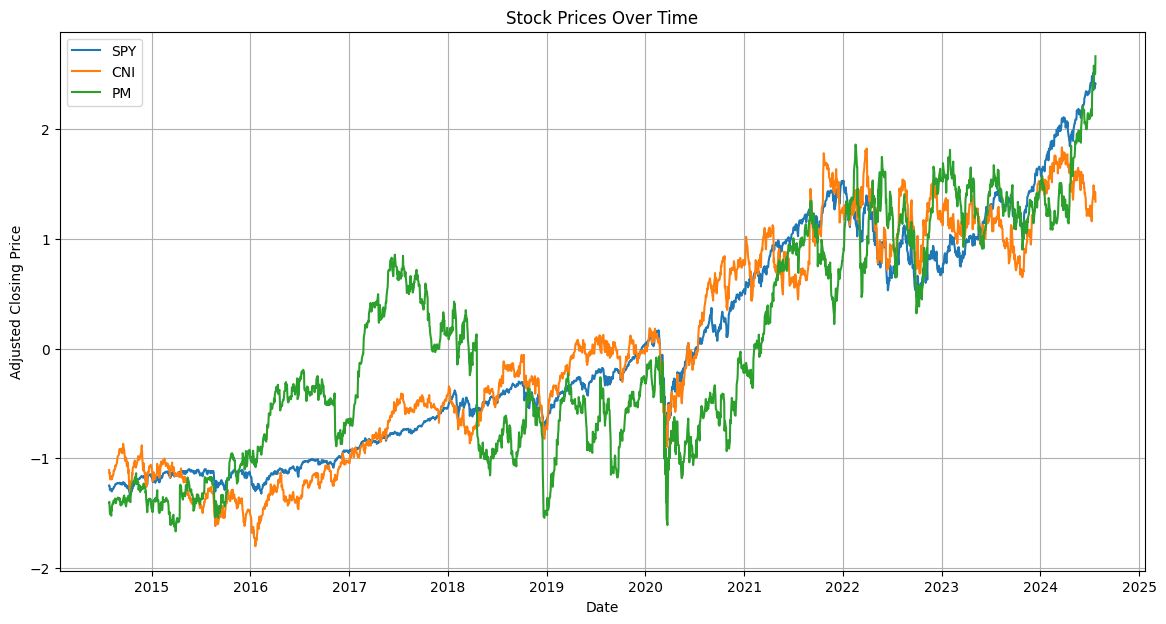

In [7]:
today_date = datetime.today()
window_days = 365*10 # This is 10 years in days window

# Define the list of stock symbols
stocks_list = [
    'SPY'
    ,'CNI'
    ,'PM'
    # ,'COST'
    # ,'WMT'

    ]

# Fetch the data
data = yf.download(
    stocks_list
    ,start=today_date - timedelta(days=window_days)
    ,end=today_date)



# The data contains multi-level columns, we'll focus on 'Adj Close' for adjusted closing prices
adj_close = data['Adj Close']

# Perform standardization using StandardScaler
scaler = StandardScaler()
standardized_data = scaler.fit_transform(adj_close)

# Convert the normalized data back to a DataFrame
standardized_data = pd.DataFrame(standardized_data, index=adj_close.index, columns=adj_close.columns)


# Plotting the adjusted closing prices of the stocks
plt.figure(figsize=(14, 7))

for stock in stocks_list:
    plt.plot(standardized_data[stock], label=stock)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import os
import pandas as pd
from decimal import Decimal
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
import yfinance as yf


import matplotlib.pyplot as plt
import plotly.express as px
import pytz  # Make sure to import pytz for timezone handling
import seaborn as sns


import requests
import csv
import json

import warnings

In [2]:
load_dotenv()

API_KEY = os.getenv("alpha_vantage_api_key")

In [3]:
# Addtional setting session
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = True

In [24]:
# Parameters section

alpha_vantage_api_key = API_KEY # FREE TIER API rate limit is 25 requests per day
ticker_symbols = [

    'IVV'
    # ,'CNI'
    # ,'PM'
]

window_days = 365*5
start_date = datetime.today()
end_date = start_date - timedelta(days=window_days)

In [42]:

for symbol in ticker_symbols:


    # Daily quote section
    # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={alpha_vantage_api_key}&outputsize=full&datatype=json'
    r = requests.get(url)
    data = r.json()

    for key, value in data.items():
        if key == 'Time Series (Daily)':


            selected_cols = [
                '4. close'
            ]

            Daily_stock_df = pd.DataFrame(value).transpose()[selected_cols] # tranpose the dataframe and sub select selected cols

            # Rename columns
            Daily_stock_df.rename(
                columns={
                    '4. close': f'{symbol}'
                    }
                ,inplace=True
                )
            
            Daily_stock_df[f'{symbol}'] = Daily_stock_df[f'{symbol}'].astype(str).apply(lambda x: float(x))
            Daily_stock_df[f'{symbol}'] = Daily_stock_df[f'{symbol}'].round(2)


    # Dividend section
    # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
    url = f'https://www.alphavantage.co/query?function=DIVIDENDS&symbol={symbol}&apikey={alpha_vantage_api_key}'
    r = requests.get(url)
    data = r.json()

    for key, value in data.items():
        if key == 'data':
            stock_dividend_df = pd.DataFrame(value)
            stock_dividend_df = stock_dividend_df[['ex_dividend_date', 'amount']]

            # Rename columns
            stock_dividend_df.rename(
                    columns={
                        'ex_dividend_date': f'{symbol}_div_date'
                        ,'amount': f'{symbol}_div_amount'
                        }
                    ,inplace=True
                    )
            
            stock_dividend_df[f'{symbol}_div_amount'] = stock_dividend_df[f'{symbol}_div_amount'].astype(str).apply(lambda x: float(x))
            stock_dividend_df[f'{symbol}_div_amount'] = stock_dividend_df[f'{symbol}_div_amount'].round(2)





    # Time window filter applied
    Daily_stock_df_filter_timewindow = Daily_stock_df[(pd.to_datetime(Daily_stock_df.index) >= end_date)
                                                & (pd.to_datetime(Daily_stock_df.index) <= start_date)
                                                ]
    
    stock_dividend_df_filter_timewindow = stock_dividend_df[(pd.to_datetime(stock_dividend_df[f'{symbol}_div_date']) >= end_date)
                                                    & (pd.to_datetime(stock_dividend_df[f'{symbol}_div_date']) <= start_date)
                                                    ]
    # Calculate the return %
    # return including dividend = (current_price - initial_price + total_dividend_during_period) / initial_price
    stock_return = (
        (
        Daily_stock_df_filter_timewindow[f'{symbol}'][0] 
        - Daily_stock_df_filter_timewindow[f'{symbol}'][-1] 
        + stock_dividend_df_filter_timewindow[f'{symbol}_div_amount'].sum()
        ) 
        / Daily_stock_df_filter_timewindow[f'{symbol}'][-1]
    )





In [43]:
stock_return

0.9359054547848702

In [38]:
Daily_stock_df_filter_timewindow[f'{symbol}'][0] - Daily_stock_df_filter_timewindow[f'{symbol}'][-1] + stock_dividend_df_filter_timewindow[f'{symbol}_div_amount'].sum()

284.3

In [39]:
Daily_stock_df_filter_timewindow[f'{symbol}'][0] - Daily_stock_df_filter_timewindow[f'{symbol}'][-1]

253.01

In [31]:
stock_dividend_df_filter_timewindow[f'{symbol}_div_amount'].sum()

31.290000000000003

In [27]:
stock_dividend_df[(pd.to_datetime(stock_dividend_df[f'{symbol}_div_date']) >= end_date)
               & (pd.to_datetime(stock_dividend_df[f'{symbol}_div_date']) <= start_date)
               ]

,IVV_div_date,IVV_div_amount
0,2024-06-11,1.61
1,2024-03-21,1.67
2,2023-12-20,1.93
3,2023-09-26,1.99
4,2023-06-07,1.34
5,2023-03-23,1.65
6,2022-12-13,1.72
7,2022-09-26,1.91
8,2022-06-09,1.28
9,2022-03-24,1.48
